<center><img src=Images/Seville_Spain.jpg width="1500"/></center>
<center>Agricultural area near Seville (Spain) seen by Sentinel-2 - Credits: Containes modified Copernicus data processed by RUS Copernicus (2020). </center>

# <center> CROP MAPPING WITH SENTINEL-1 and SENTINEL-2 <br><br> Case Study: Argentina - 2018-2019 </center> 
<center>
    Author: Tereza Roth - <a href="mailto:tereza.roth@serco.com"> tereza.roth@serco.com</a> 
    <br> 
    This work is licensed under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/"> Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a></center>
<br>
<br>
<p style='text-align: justify;'> Reliable information on agriculture and crops is required to assist and help in the decision-making process of different applications. Different methods can be used to gather this information, but satellite earth observation offers a suitable approach based on the coverage and type of data that are provided.
A few years ago, the European Union (EU) started an ambitious program, Copernicus, which includes the launch of a new family of earth observation satellites known as the Sentinels. Amongst other applications, this new generation of remote sensing satellites will improve the observation, identification, mapping, assessment, and monitoring of crop dynamics at a range of spatial and temporal resolutions. </p>

<div class="alert alert-block alert-info">
<b>Tip:</b> More informatin on the characteristics of Sentinel-1 and Sentinel-2 can be found <a href="https://sentinel.esa.int/web/sentinel/missions/"> here </a>
</div>

<p style='text-align: justify;'>The analysis will be implemented using Python code that can be found in this Jupyter Notebook. The exercise <strong>DOES NOT</strong> require any Pyhton programming skills and can be followed by any participant. You will not be asked to write any code but to follow the methodology and understand the processign steps. If you are new to Python or Jupyter Lab, here are some references that can help you:</p>


- [Python Tutorial](https://docs.python.org/3/tutorial/)
- [Jupyter Notebook documentation](https://jupyter.readthedocs.io/en/latest/index.html)
- [Jupyter Notebook tutorial](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html)


The exercise is divided in the following sections:
1. Load Python packages
2. User input
3. Load and visualize input data
4. Create Training/Validation data
5. Supervised classification - Random Forest
6. Supervised classification - SVM
7. Unsupervised clustering - K-means
 
Let's now start the exercise by loading all the modules required to run the analysis.

<font size="5" color="#00A0B2"  face="verdana"> <B>1- Load Python packages</B></font>

<div class="alert alert-block alert-info">
<b>Tip:</b> To run the code, click in the code cell you want to run and press <span style="background-color: #D3D3D3">CTRL</span> + <span style="background-color: #D3D3D3">ENTER</span>. Alternatively, you can also go to `Run -> Run Selected Cells`
</div>
   

In [1]:
# MODULE                                                        # DESCRIPTION
import os 
import numpy as np                                              # scientific computing 
import matplotlib as mtp                                        # create visualizations
import matplotlib.pyplot as plt                                 # create visualizations
import pandas as pd                                             # data analysis and manipulation
import geopandas as gpd                                         # extends the datatypes used by pandas to allow spatial operations on geom. types
import earthpy.plot as ep                                       # plot and work with spatial raster and vector data using open source tools 
import rasterio                                                 # Rasterio reads and writes raster formats and provides a Python API based 
import snappy
from rasterio.plot import reshape_as_raster, reshape_as_image   # on Numpy N-dimensional arrays and GeoJSON

In [2]:
from snappy import ProductIO                                  # SNAP python interface

In [3]:
# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline              

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

Current working directory: /home/vyago/Documents/ARSET/CropClassSAR/part4/ARSET_Part4_TrainingKit


<font size="5" color="#8b1900"  face="verdana"> <B>2. User input data </B></font>

The paths to the required input data. YOU HAVE TO EDIT THE PATHS TO DATA ACCORDINGLY!!!

In [4]:
# Path to preprocessed and co-located Sentinel-1 and Sentinel-2 stack
S1_S2_stack = './Processing/S1_S2_stack.tif'

# Path to Training and Validation point shapefiles
training_points = './Shapefiles/Training_points1000.shp'
validation_points = './Shapefiles/Validation_points200.shp'

class_names = ['Maize', 'Soybean', 'Winter Crop - Soybean', 'Winter Crop - Maize', 'Peanut', 'Rangeland/Pastures', 
               'Natural woody vegetation', 'Masked']  # Eight classes represented in our training data. 

<font size="5" color="#8b1900"  face="verdana"> 2.1 Create custom color map </font>

In this step we will create a custom color for the visualization of our classification results. 

In [5]:
# create a color dictionary with specific colors assigned to specific crop type. 
colors = dict((
    (0, (0,76,153,255)),     # blue - Maize
    (1, (0,153,0,255)),      # green - Soybean
    (2, (255,0,0,255)),      # red - Winter Crop - Soybean
    (3, (255,153,51,255)),   # orange - Winter Crop - Maize
    (4, (255,255,0,255)),    # yellow - Peanut
    (5, (204,153,255,255)),  # purple - Rangeland/Pasture
    (6, (178,255,102,255)),  # light green - Natural woody vegetation
    (7, (0,0,0,255))         # black - Masked
))

# Convert 0 - 255 values to float in range 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

# Cleate matplotlib colormap from a list of colors and call it Classification   
index_colors = [colors[key] if key in colors else (1, 1, 1, 0) for key in range(0, 8)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 8)

<font size="5" color="#8b1900"  face="verdana"> <B>3. Load and visualize input data</B></font>

<font size="5" color="#8b1900"  face="verdana"> 3.1 Visualize a RGB composite of first Sentinel-2 image and first Sentinel-1 image </font>

In [6]:
# Loads the input dataset into a dataset object
src = rasterio.open(S1_S2_stack)

In [7]:
# Get list of band names, uses snappy package 
prep_vis = snappy.ProductIO.readProduct(S1_S2_stack)
bands = list(prep_vis.getBandNames())

(104, 2001, 2066)


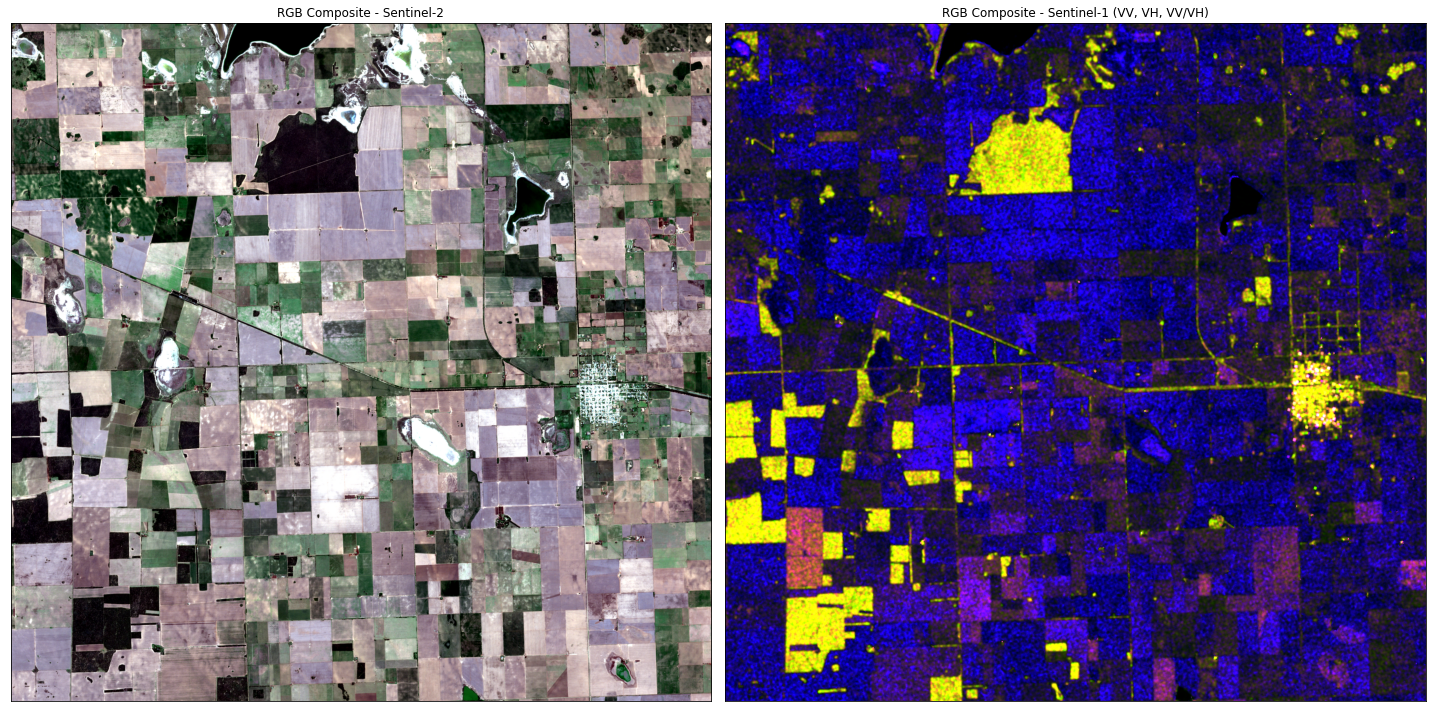

In [8]:
# read all bands of the dataset into 3-dimensional array stack - (band, row, column)
stack = src.read() 
print(stack.shape)
# Create a figure and plot the RGB composites of first Sentinel-2 image (True color) and first Sentinel-1 image (Dual Pol Ratio VV+VH)
# The band numbers must be changed accordingly to your input dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1 = ep.plot_rgb(arr = stack, rgb = (2, 1, 0), stretch=True, ax = ax1, title="RGB Composite - Sentinel-2")
stack_s1 = np.stack((stack[60], stack[61], stack[61]/stack[60]))  # When using the S1_S2_stack_subset10.tif - the respective bands are 30 and 31 
ax2 = ep.plot_rgb(arr = stack_s1, rgb = (1, 0, 2), stretch=True, ax = ax2, title="RGB Composite - Sentinel-1 (VV, VH, VV/VH)")
plt.tight_layout()

<font size="5" color="#8b1900"  face="verdana"> <B>4. Create Training/Validation data</B></font>

In this section we will load and preapre and visualize our training and validation dataset.

In [9]:
# Magic code - this piece if code simply creates an exact copy of our input dataset and saves it in memory file. 
# There should be no reason to do this but this step increases the speed of the trainnig data extraction 
# from 2 hrs without it to 10 sec with creating the copy.
img = src.read()   # load our original input file bands to a numby array stack
profile = src.profile  # the copy the profile of the original GeoTIFF input file
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        for i in range(0, src.count):
            dst.write(img[i], i+1)
    dataset = memfile.open()

<font size="5" color="#8b1900"  face="verdana"> 4.2 Extract training dataset</font>

In [10]:
# Read points from shapefile
train_pts = gpd.read_file(training_points) 
train_pts = train_pts[['GRIDCODE', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
train_pts.index = range(len(train_pts))
coords = [(x,y) for x, y in zip(train_pts.UTM_E, train_pts.UTM_N)]  # Create list of point coordinates

# Sample the each band of raster dataset at each point in the coordinate list
train_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
train_pts[bands] = pd.DataFrame(train_pts['Raster Value'].tolist(), index= train_pts.index)  
train_pts = train_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column
# Change the values for last three classes - original class numbers [0,1,2,3,4,7,8,15] -> [0,1,2,3,4,5,6,7]
train_pts['GRIDCODE'] = train_pts['GRIDCODE'].replace([7,8,15],[5,6,7]) 
train_pts.to_csv('train_pts.csv') # save our training dataset to CSV
train_pts.head() # visualize the first rows of the dataframe 

,GRIDCODE,UTM_E,UTM_N,geometry,B2_S0,B3_S0,B4_S0,B8_S0,B11_S0,B12_S0,...,Sigma0_VH_slv33_09Apr2019,Sigma0_VV_slv34_09Apr2019,Sigma0_VH_slv35_21Apr2019,Sigma0_VV_slv36_21Apr2019,Sigma0_VH_slv37_03May2019,Sigma0_VV_slv38_03May2019,Sigma0_VH_slv39_15May2019,Sigma0_VV_slv40_15May2019,Sigma0_VH_slv41_27May2019,Sigma0_VV_slv42_27May2019
0,7,343899.762,6154031.799,POINT (343899.762 6154031.799),1743.0,1720.0,1965.0,2281.0,2549.0,2078.0,...,0.003223,0.036596,0.002547,0.048084,0.001968,0.021274,0.001002,0.011937,0.003172,0.068938
1,7,343858.770,6154555.736,POINT (343858.770 6154555.736),1033.0,973.0,1039.0,873.0,135.0,106.0,...,0.003007,0.051258,0.000874,0.003302,0.000882,0.003045,0.000857,0.003962,0.000800,0.003281
2,7,343758.991,6154602.729,POINT (343758.991 6154602.729),1053.0,953.0,1000.0,1103.0,172.0,135.0,...,0.002112,0.051053,0.001084,0.003342,0.000643,0.002636,0.000808,0.005617,0.000750,0.002826
3,7,343841.886,6154525.136,POINT (343841.886 6154525.136),1045.0,999.0,1051.0,953.0,140.0,107.0,...,0.002572,0.035816,0.000782,0.003333,0.001269,0.002526,0.000807,0.004431,0.000943,0.002205
4,7,343982.887,6154448.604,POINT (343982.887 6154448.604),1229.0,1122.0,1231.0,1412.0,1485.0,1088.0,...,0.002519,0.046755,0.004190,0.065402,0.000952,0.007841,0.000934,0.004372,0.001531,0.036575


In [11]:
# Check if class numbers were correctly changed
train_pts['GRIDCODE'].unique() 

array([7, 2, 0, 5, 1, 3, 4, 6])

/home/vyago/miniconda3/envs/cropMap/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


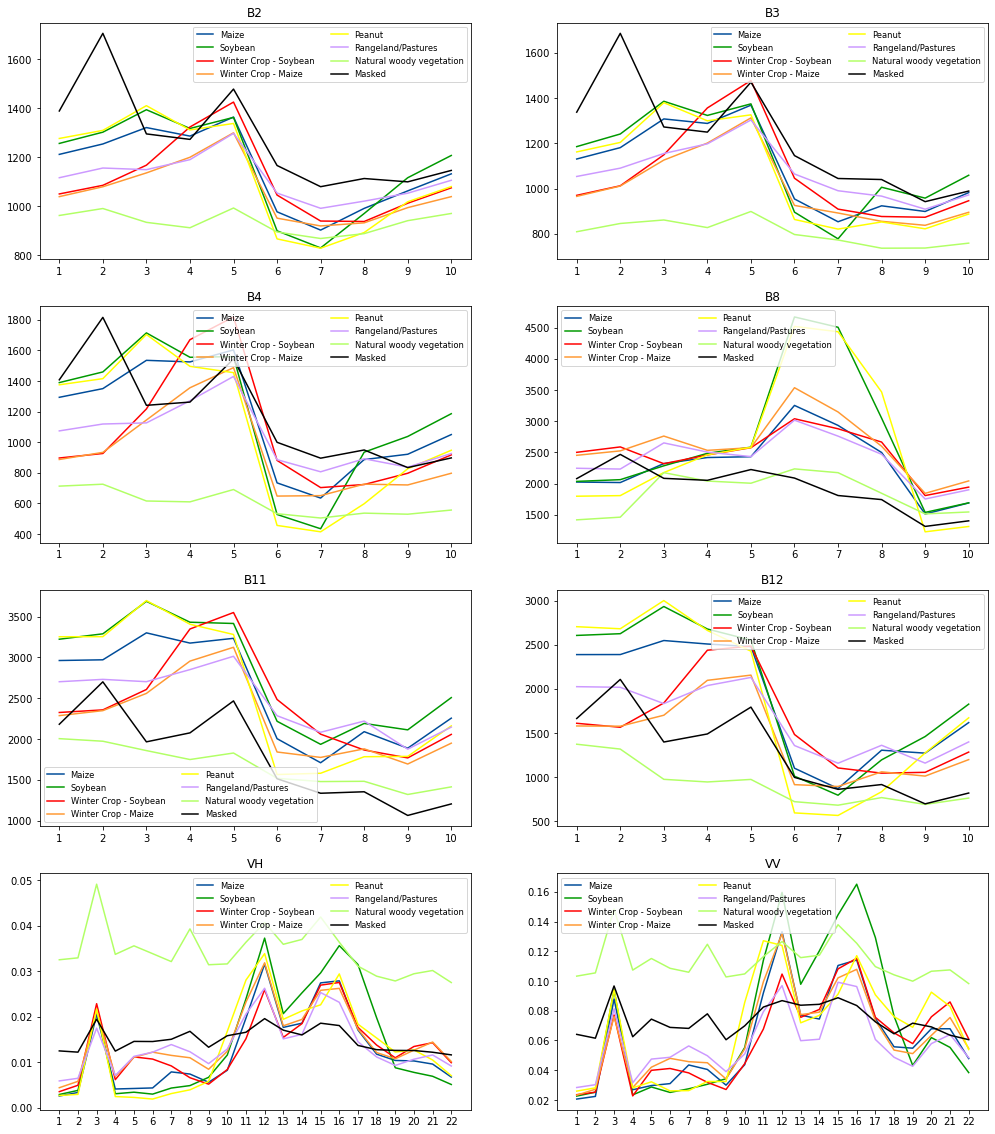

In [12]:
# Plot Class profiles over our dataset (September 2018 - June 2019)
prof = train_pts.groupby(['GRIDCODE']).mean()  #calculate average value for each class in each band
fig = plt.figure(figsize = (17,20)) 
band_n = ['B2','B3','B4','B8','B11','B12','VH','VV'] # bands we included in the analysis for each name we have multiple dates included
n = 1  # counter
for ba in band_n:  # Iterate over band names
    ax = fig.add_subplot(4,2,n) 
    ax.title.set_text(ba)
    band_val = prof[prof.columns[prof.columns.to_series().str.contains(ba)]]  # Select all columns in the dataframe containing a band name e.g. B2
    for index, row in band_val.iterrows():  # Plot line for each class in the selected band
        color = cmap(index)  
        ax.plot(row, color=color) 
    ax.set_xticklabels([str(x) for x in range(1, len(row)+1)])  # Replace column names with numbers
    ax.legend(loc="best", fontsize='small', ncol=2, labels=class_names)
    n = n+1

In [13]:
# Split training dataset to labels (y) and input features (x)
y = train_pts['GRIDCODE'].values  
# We create a different x dataset based on the subset we want to use for training our model
x = []
x.append(train_pts[[b for b in bands if "Sigma0" in b]].values)   # Only Sentinel-1 data
x.append(train_pts[[b for b in bands if "B" in b]].values)  # Only Sentinel-2 data
x.append(train_pts[bands].values)  # all Sentinel-1 and Sentinel-2 data
del(train_pts, coords)  

In [14]:
# Check the shapes of our feature datasets
print('The trainng data sizes are: Sentinel-1 stack: ', x[0].shape, 
      'Sentinel-2 stack: ', x[1].shape, 
      'Sentinel-1 and Sentinel-2 stack: ', x[2].shape)

The trainng data sizes are: Sentinel-1 stack:  (8000, 44) Sentinel-2 stack:  (8000, 60) Sentinel-1 and Sentinel-2 stack:  (8000, 104)


<font size="5" color="#8b1900"  face="verdana"> 4.3 Extract validation dataset</font>

Our validation set has the same format as the training dataset, but different polygons were sampled in this case to ensure the independence of training and validation data. 

In [15]:
# Read points from shapefile
valid_pts = gpd.read_file(validation_points)
valid_pts = valid_pts[['GRIDCODE', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
valid_pts.index = range(len(valid_pts))
coords = [(x,y) for x, y in zip(valid_pts.UTM_E, valid_pts.UTM_N)]  # Create list of point coordinates
# Sample the each band of raster dataset at each point in the coordinate list
valid_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
valid_pts[bands] = pd.DataFrame(valid_pts['Raster Value'].tolist(), index= valid_pts.index)
valid_pts = valid_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column
# Change the values for last three classes - original class numbers [0,1,2,3,4,7,8,15] -> [0,1,2,3,4,5,6,7]
valid_pts['GRIDCODE'] = valid_pts['GRIDCODE'].replace([7,8,15],[5,6,7])
valid_pts.to_csv('valid_pts.csv')   # save our validation dataset to CSV
valid_pts.head()   # visualize the first rows of the dataframe 

,GRIDCODE,UTM_E,UTM_N,geometry,B2_S0,B3_S0,B4_S0,B8_S0,B11_S0,B12_S0,...,Sigma0_VH_slv33_09Apr2019,Sigma0_VV_slv34_09Apr2019,Sigma0_VH_slv35_21Apr2019,Sigma0_VV_slv36_21Apr2019,Sigma0_VH_slv37_03May2019,Sigma0_VV_slv38_03May2019,Sigma0_VH_slv39_15May2019,Sigma0_VV_slv40_15May2019,Sigma0_VH_slv41_27May2019,Sigma0_VV_slv42_27May2019
0,7,352062.865,6154581.919,POINT (352062.865 6154581.919),1579.0,1552.0,1684.0,2507.0,1939.0,1021.0,...,0.005520,0.027479,0.006149,0.034680,0.008686,0.036148,0.002562,0.035704,0.004415,0.033445
1,7,352125.691,6154599.221,POINT (352125.691 6154599.221),2479.0,2531.0,2841.0,3416.0,2946.0,2090.0,...,0.002742,0.017917,0.002171,0.016295,0.003571,0.020160,0.002075,0.016422,0.002705,0.017495
2,3,357290.963,6154540.238,POINT (357290.963 6154540.238),890.0,754.0,516.0,3071.0,1779.0,1058.0,...,0.013282,0.066702,0.012339,0.078793,0.014564,0.075794,0.024041,0.085614,0.013150,0.074037
3,3,357327.372,6154574.794,POINT (357327.372 6154574.794),963.0,875.0,746.0,2336.0,1895.0,1237.0,...,0.012152,0.066013,0.012361,0.069973,0.011917,0.078306,0.019011,0.095753,0.015859,0.085300
4,2,347366.879,6153867.097,POINT (347366.879 6153867.097),1169.0,1126.0,1256.0,2118.0,2502.0,2128.0,...,0.013084,0.102301,0.021367,0.121846,0.012780,0.124226,0.020636,0.147172,0.012773,0.085978


In [16]:
# Split validation dataset to training and validation data
y_valid = valid_pts['GRIDCODE'].values
# We create a different x dataset based on the subset we want to use for training our model
x_valid = []
x_valid.append(valid_pts[[b for b in bands if "Sigma0" in b]].values)   # Only Sentinel-1 data
x_valid.append(valid_pts[[b for b in bands if "B" in b]].values)  # Only Sentinel-2 data
x_valid.append(valid_pts[bands].values)  # all Sentinel-1 and Sentinel-2 data
del(valid_pts, coords)

In [17]:
# Check the shapes of our feature datasets
print('The validation data sizes are: Sentinel-1 stack: ', x_valid[0].shape, 
      'Sentinel-2 stack: ', x_valid[1].shape, 
      'Sentinel-1 and Sentinel-2 stack: ', x_valid[2].shape)

The validation data sizes are: Sentinel-1 stack:  (1345, 44) Sentinel-2 stack:  (1345, 60) Sentinel-1 and Sentinel-2 stack:  (1345, 104)


<font size="5" color="#8b1900"  face="verdana"> <B>5. Random Forest Classification</B></font>

The Random Forest (RF) algorithm is a machine learning technique that can be used for classification or regression. In opposition to parametric classifiers (e.g. Maximum Likelihood), a machine learning approach does not start with a data model but instead learns the relationship between the training and the response dataset. The Random Forest classifier is an aggregated model, which means it uses the output from different models (trees) to calculate the response variable.

Decision trees are predictive models that recursively split a dataset into regions by using a set of binary rules to calculate a target value for classification or regression purposes. Given a training set with n number of samples and m number of variables, a random subset of samples n is selected with replacement (bagging approach) and used to construct a tree. At each node of the tree, a random selection of variables m is used and, out of these variables, only the one providing the best split is used to create two sub-nodes.

By combining trees, the forest is created. Each pixel of a satellite image is classified by all the trees of the forest, producing as many classifications as number of trees. Each tree votes for a class membership and then, the class with the maximum number of votes is selected as the final class.
<br><br>
<center><img src=Images/RandomForest.png width="600"/></center>

In this exercise we will be using the Random Forest implementation provided by the `scikit-learn` library. 

<font size="5" color="#8b1900"  face="verdana"> 5.1 Train the RF classifier</font>

First we need to teach/train our model to differentiate between classes based on the values of the bands (features) in the training data we have created above.

<div class="alert alert-block alert-warning">
<b>RF parameters and default values:</b>    

```Python
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
```
</div>

In [18]:
from sklearn.ensemble import RandomForestClassifier

model_RF = []
for i in range(0, 3):  #  Loop over our three feature datasets and fit a RF model to each
    rf = RandomForestClassifier(n_estimators=300, oob_score=True, max_features='auto')   # Initialize our model with 500 trees and the default parameters
    rf = rf.fit(x[i], y)   # Fit the model to the training dataset
    model_RF.append(rf)  # Save the trained model to a list
rf = None    
# The OOB score of the training dataset obtained using an out-of-bag estimate. 
print('Our OOB prediction of accuracy for S1 stack is: {oob}%'.format(oob=model_RF[0].oob_score_ * 100))
print('Our OOB prediction of accuracy for S2 stack is: {oob}%'.format(oob=model_RF[1].oob_score_ * 100))
print('Our OOB prediction of accuracy for S1 and S2 stack is: {oob}%'.format(oob=model_RF[2].oob_score_ * 100))

Our OOB prediction of accuracy for S1 stack is: 87.7125%
Our OOB prediction of accuracy for S2 stack is: 90.5875%
Our OOB prediction of accuracy for S1 and S2 stack is: 91.4875%


<font size="5" color="#8b1900"  face="verdana"> 5.2 RF Model Validation</font>

Test the performance of our trained model on portion of the data that was not used for the training but for which we know the correct labels.

In [19]:
from sklearn.metrics import classification_report

label = ['Sentinel-1 only', 'Sentinel-2 only', 'Sentinel-1 and Sentinel-2 stack']
# Run prediction on the test datastet
for i in range(0, 3):  # Loop over the trained RF models
    rf = model_RF[i]  # Load the trainied model
    y_pred = rf.predict(x_valid[i])  
    print(label[i])
    print(classification_report(y_valid, y_pred, target_names=class_names))  # Print the classification report

Sentinel-1 only
                          precision    recall  f1-score   support

                   Maize       0.24      0.13      0.17       150
                 Soybean       0.71      0.81      0.76       200
   Winter Crop - Soybean       0.40      0.43      0.41       171
     Winter Crop - Maize       0.26      0.64      0.37        84
                  Peanut       0.79      0.62      0.70       189
      Rangeland/Pastures       0.52      0.36      0.42       200
Natural woody vegetation       0.96      0.91      0.94       151
                  Masked       0.89      0.93      0.91       200

                accuracy                           0.61      1345
               macro avg       0.60      0.60      0.58      1345
            weighted avg       0.63      0.61      0.61      1345

Sentinel-2 only
                          precision    recall  f1-score   support

                   Maize       0.15      0.13      0.14       150
                 Soybean       0.61     

<font size="5" color="#8b1900"  face="verdana"> 5.3 Classify the image with the trained RF model </font>

Finally we will use out trained model to classify our input image (full or subset).

In [20]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
# You may need to reduce image size if your kernel crashes, as this step takes a lot of memory
img = dataset.read()  # img = dataset.read()[:, 150:600, 250:1400]
print(img.shape)  # (bands, rows, cols)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)  # (rows, cols, bands)
# Reshape to 2D array
band_num_S1 = [bands.index(l) for l in bands if "Sigma0" in l][0]  # start index for Sentinel-1 bands
band_num_S2 = [bands.index(l) for l in bands if "B" in l][0]       # start index for Sentinel-2 bands
#  Create a reshaped image input for each of our trained models (used also in SVM)
class_input_S1 = reshaped_img[:, :, band_num_S1: band_num_S1 + x[0].shape[1]].reshape(-1, x[0].shape[1])
class_input_S2 = reshaped_img[:, :, band_num_S2: band_num_S2 + x[1].shape[1]].reshape(-1, x[1].shape[1])
class_input_S1S2 = reshaped_img.reshape(-1, x[2].shape[1])
print(class_input_S1S2.shape)  # (rows*cols, bands)

(104, 2001, 2066)
(2001, 2066, 104)
(4134066, 104)


In [21]:
# Sentinel-1 stack classification
rf_S1 = model_RF[0]
class_RF_S1 = rf_S1.predict(class_input_S1)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_RF_S1 = class_RF_S1.reshape(reshaped_img[:, :, 0].shape)

In [22]:
# Sentinel-2 stack classification
rf_S2 = model_RF[1]
class_RF_S2 = rf_S2.predict(class_input_S2)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_RF_S2 = class_RF_S2.reshape(reshaped_img[:, :, 0].shape)

In [23]:
# Sentinel-1 and Sentinel-2 stack classification
rf_S1S2 = model_RF[2]
class_RF_S1S2 = rf_S1S2.predict(class_input_S1S2)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_RF_S1S2 = class_RF_S1S2.reshape(reshaped_img[:, :, 0].shape)

<font size="5" color="#8b1900"  face="verdana"> 5.4 Visualize RF results </font>

Finally we will use out trained model to classify the last image in our time series.

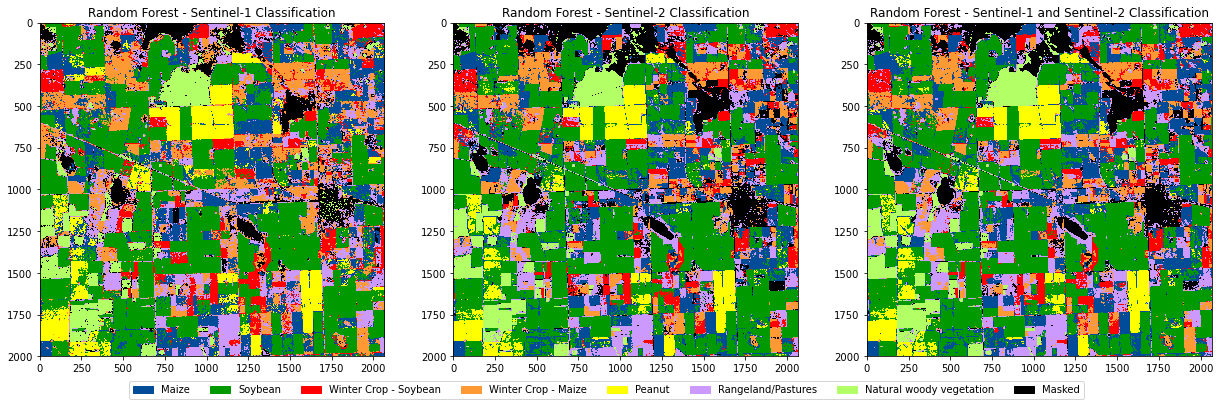

In [24]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(21, 21))
ax1.set_title('Random Forest - Sentinel-1 Classification')
im1 = ax1.imshow(class_RF_S1, cmap=cmap, interpolation='none')
ax2.set_title('Random Forest - Sentinel-2 Classification')
im2 = ax2.imshow(class_RF_S2, cmap=cmap, interpolation='none')
ax3.set_title('Random Forest - Sentinel-1 and Sentinel-2 Classification')
im3 = ax3.imshow(class_RF_S1S2, cmap=cmap, interpolation='none')

# Create a legend with class names and colors
patches = [mtp.patches.Patch(color=cmap(i), label="{:s}".format(class_names[i]) ) for i in range(len(class_names)) ]
fig.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.37), ncol=9 )

In [25]:
# Save our classification results into a GeoTIFF 
with rasterio.Env():
    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile
    # change the band count to 3, set the dtype to uint8, and specify LZW compression.
    profile.update(dtype=rasterio.uint8, count=3, compress='lzw')
    with rasterio.open('RF_classification.tif', 'w', **profile) as dst:
        dst.write(class_RF_S1.astype(rasterio.uint8), 1)
        dst.write(class_RF_S2.astype(rasterio.uint8), 2)
        dst.write(class_RF_S1S2.astype(rasterio.uint8), 3)

# At the end of the ``with rasterio.Env()`` block, context manager exits and all drivers are de-registered.

<font size="5" color="#00A0B2"  face="verdana"> <B>6. Support Vector Machine (SVM) supervised classification</B></font>

<p style='text-align: justify;'> 
 
When classifying using SVM, the following steps will be followed:
- Tune SVM parameters using a 10-k cross-validation
- Train the SVM model using the best parameters
- Run the classification using the trained model
    
<div class="alert alert-block alert-info">
<b>Tip:</b> More information on SVM can be found <a href="https://en.wikipedia.org/wiki/Support-vector_machine"> here. </a> A graphical example of the effect of the SVM parameters can be found <a href="https://cs.stanford.edu/people/karpathy/svmjs/demo/"> here. </a>
</div>

</p>


<font size="5" color="#8b1900"  face="verdana"> 6.1 Train the SVM classifier</font>

First we need to teach/train our model to differentiate between classes based on the values of the bands (features) in the training data we have created above.

<div class="alert alert-block alert-warning">
<b>SVM parameters and default values:</b>    

```Python
class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)
```
</div>

In [26]:
from sklearn import svm

model_SVM = []
for i in range(0, 3):  #  Loop over our three feature datasets and fit a SVM model to each
    svm_ = svm.SVC()  # Initialize our model with the default parameters
    svm_ = svm_.fit(x[i], y)  # Fit the model to the training dataset
    model_SVM.append(svm_)

<font size="5" color="#8b1900"  face="verdana"> 6.2 SVM Model Validation</font>

Test the performance of our trained model on portion of the data that was not used for the training but for which we know the correct labels.

In [27]:
label = ['Sentinel-1 only', 'Sentinel-2 only', 'Sentinel-1 and Sentinel-2 stack']
# Run prediction on the test datastet
for i in range(0, 3):
    svm = model_SVM[i]
    y_pred_svm = svm.predict(x_valid[i])
    print(label[i])
    print(classification_report(y_valid, y_pred_svm, target_names=class_names))

Sentinel-1 only
                          precision    recall  f1-score   support

                   Maize       0.09      0.09      0.09       150
                 Soybean       0.64      0.81      0.71       200
   Winter Crop - Soybean       0.36      0.38      0.37       171
     Winter Crop - Maize       0.30      0.40      0.35        84
                  Peanut       0.73      0.66      0.69       189
      Rangeland/Pastures       0.65      0.45      0.53       200
Natural woody vegetation       0.97      0.93      0.95       151
                  Masked       0.92      0.92      0.92       200

                accuracy                           0.60      1345
               macro avg       0.58      0.58      0.58      1345
            weighted avg       0.61      0.60      0.60      1345

Sentinel-2 only
                          precision    recall  f1-score   support

                   Maize       0.34      0.27      0.30       150
                 Soybean       0.83     

<font size="5" color="#8b1900"  face="verdana"> 6.3 Classify the image with the trained SVM model </font>

Here we will use our trained SVM models to classify the full image using the S1, S2 and combined S1 and S2 bands.

In [28]:
# Sentinel-1 stack classification
svm_ = model_SVM[0]
class_SVM_S1 = svm_.predict(class_input_S1)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_SVM_S1 = class_SVM_S1.reshape(reshaped_img[:, :, 0].shape)

In [29]:
# Sentinel-2 stack classification
svm_ = model_SVM[1]
class_SVM_S2 = svm_.predict(class_input_S2)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_SVM_S2 = class_SVM_S2.reshape(reshaped_img[:, :, 0].shape)

In [30]:
# Sentinel-1 and Sentinel-2 stack classification
svm_ = model_SVM[2]
class_SVM_S1S2 = svm_.predict(class_input_S1S2)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_SVM_S1S2 = class_SVM_S1S2.reshape(reshaped_img[:, :, 0].shape)

<font size="5" color="#8b1900"  face="verdana"> 6.4 Visualize SVM results </font>

Finally we will use out trained models to classify the last image in our time series.

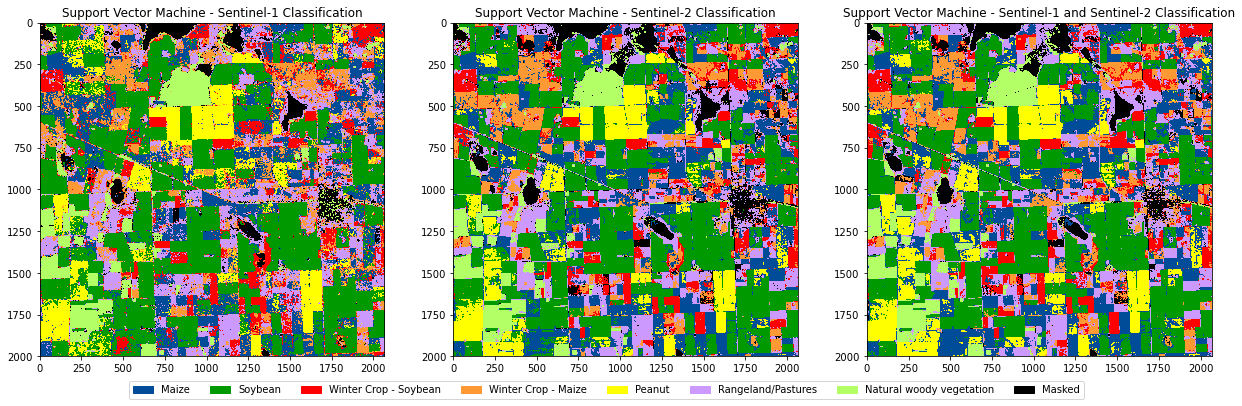

In [31]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(21, 21))
ax1.set_title('Support Vector Machine - Sentinel-1 Classification')
im1 = ax1.imshow(class_SVM_S1, cmap=cmap, interpolation='none')
ax2.set_title('Support Vector Machine - Sentinel-2 Classification')
im2 = ax2.imshow(class_SVM_S2, cmap=cmap, interpolation='none')
ax3.set_title('Support Vector Machine - Sentinel-1 and Sentinel-2 Classification')
im3 = ax3.imshow(class_SVM_S1S2, cmap=cmap, interpolation='none')

# Create a legend with class names and colors
patches = [mtp.patches.Patch(color=cmap(i), label="{:s}".format(class_names[i]) ) for i in range(len(class_names)) ]
fig.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.37), ncol=9 )

In [32]:
with rasterio.Env():
    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile
    # And then change the band count to 3, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

    with rasterio.open('SVM_classification.tif', 'w', **profile) as dst:
        dst.write(class_SVM_S1.astype(rasterio.uint8), 1)
        dst.write(class_SVM_S2.astype(rasterio.uint8), 2)
        dst.write(class_SVM_S1S2.astype(rasterio.uint8), 3)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.

<font size="5" color="#00A0B2"  face="verdana"> <B>7. K-means unsupervised classification</B></font>


<div class="alert alert-block alert-info">
<b>Tip:</b> More information on K-means can be found <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html"> here </a>
</div>
The algorithm is composed of the following steps:
    
1. Place K points into the space represented by the objects that are being clustered. These points represent initial group centroids.
2. Assign each object to the group that has the closest centroid.
3. When all objects have been assigned, recalculate the positions of the K centroids.
4. Repeat Steps 2 and 3 until the centroids no longer move. This produces a separation of the objects into groups from which the metric to be minimized can be calculated.
<br><br>
<a title="Chire [CC BY-SA (https://creativecommons.org/licenses/by-sa/4.0)]" href="https://commons.wikimedia.org/wiki/File:K-means_convergence.gif"><img width="312" alt="K-means convergence" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/K-means_convergence.gif/512px-K-means_convergence.gif"></a>
<a href="https://commons.wikimedia.org/wiki/File:K-means_convergence.gif" title="via Wikimedia Commons">Chire</a> [<a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA</a>]

<div class="alert alert-block alert-warning">
<b>K-means parameters and default values:</b>    

```Python
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
```
</div>


<font size="5" color="#8b1900"  face="verdana"> 7.1 Normalize the dataset</font>

Scaling is done to normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance such as K-means.

In [33]:
from sklearn.preprocessing import StandardScaler
img = dataset.read()
normalized = []
scaler = StandardScaler()   # Initialize standard scaler
for i in range(0, dataset.count):  # Loop over bands in our input dataset
    sc = scaler.fit(img[i, :, :])   # Fit scaler to calculate mean and standard deviation
    scaled = scaler.transform(img[i, :, :])    # Use the mean and standard deviation to scale all values in the band
    normalized.append(scaled)    # append result to an array list
normalized = np.stack(normalized, axis=0)    # convert array list to numpy array stack
# Reshape the stack to 2d array
reshaped_norm = reshape_as_image(normalized)
norm_input_S1S2 = reshaped_norm.reshape(-1, normalized.shape[0])
print(norm_input_S1S2.shape)

(4134066, 104)


<font size="5" color="#8b1900"  face="verdana"> 7.2 Run clustering and visualize results</font>

In [ ]:
from sklearn.cluster import KMeans

k = 10 # num of clusters
clus_kmeans = KMeans(n_clusters=k, random_state=0).fit(norm_input_S1S2)  # Initialize and fit the K-means model
clus_kmeans = clus_kmeans.labels_.reshape(reshaped_img[:, :, 0].shape) 

In [ ]:
# Now show the cluster map next to the Sentinel-2 True Color composite image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 10))
ax1 = ep.plot_rgb(arr = stack, rgb = (2, 1, 0), stretch=True, ax = ax1, title="RGB Composite - Sentinel-2")
ax2 = ax2.imshow(clus_kmeans, cmap='Set1')

In [ ]:
with rasterio.Env():
    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile
    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

    with rasterio.open('Kmeans_clustering.tif', 'w', **profile) as dst:
        dst.write(clus_kmeans.astype(rasterio.uint8), 1)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.

# <center>Thank you!</center> 